In [ ]:
import qlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import statsmodels.api as sm
from qlib.data import D
from qlib.config import REG_CN
from qlib.contrib.data.handler import Alpha158
from qlib.data.filter import NameDFilter, ExpressionDFilter
from qlib.contrib.model.gbdt import LGBModel
from qlib.contrib.data.handler import Alpha158
from qlib.utils import init_instance_by_config, flatten_dict
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, PortAnaRecord
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError. CatBoostModel are skipped. (optional: maybe installing CatBoostModel can fix it.)
ModuleNotFoundError. XGBModel is skipped(optional: maybe installing xgboost can fix it).
ModuleNotFoundError.  PyTorch models are skipped (optional: maybe installing pytorch can fix it).


In [ ]:
qlib.init(provider_uri='data/day1_data_qlib', region=REG_CN)
expressionDFilter = ExpressionDFilter(rule_expression='$volume != 0')
instruments = D.instruments(market = 'all', filter_pipe=[expressionDFilter])
new = D.features(instruments = instruments, fields = ['$new'], start_time = '2022-01-01', end_time = '2025-07-07', freq = 'day').unstack().T.droplevel(0)
ST = D.features(instruments = instruments, fields = ['$ST'], start_time = '2022-01-01', end_time = '2025-07-07', freq = 'day').unstack().T.droplevel(0)
marketcap = D.features(instruments = instruments, fields = ['$marketcap'], start_time = '2022-01-01', end_time = '2025-07-07', freq = 'day').unstack().T.droplevel(0)
yjl = D.features(instruments = instruments, fields = ['$CONVERTIBLEPREMIUMRATE'], start_time = '2022-01-01', end_time = '2025-07-07', freq = 'day').unstack().T.droplevel(0)
data_close = D.features(instruments = instruments, fields = ['$close'], start_time = '2022-01-01', end_time = '2025-07-07', freq = 'day').unstack().T.droplevel(0)
data_open = D.features(instruments = instruments, fields = ['$open'], start_time = '2022-01-01', end_time = '2025-07-07', freq = 'day').unstack().T.droplevel(0)
QS = pd.read_csv('数据/CBredeem.csv').pivot(index='TRADINGDATE', columns='SYMBOL9', values='FACTORVALUE')
QS.index = pd.to_datetime(QS.index)
# stock_list = D.list_instruments(instruments = instruments,
#                                 start_time='2022-01-01',
#                                 end_time='2025-03-31',
#                                 as_list=True)

[13888:MainThread](2025-07-09 15:13:00,911) INFO - qlib.Initialization - [config.py:420] - default_conf: client.
[13888:MainThread](2025-07-09 15:13:00,921) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[13888:MainThread](2025-07-09 15:13:00,923) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/tantra/Desktop/data/day1_data_qlib')}


In [ ]:
OVD = pd.read_csv('C:/Users/tantra/Desktop/数据/Fund_allValueDev.csv')
OVD = OVD.pivot(index='TRADINGDATE', columns='SYMBOL9', values='FACTORVALUE')
OVD.index = pd.to_datetime(OVD.index)
OVD = OVD.loc['2022-01-01':'2025-07-07'].dropna(how='all', axis=1)
#纯债溢价率
SPR = pd.read_csv('C:/Users/tantra/Desktop/数据/Fund_StrbPremiumRate.csv')
SPR = SPR.pivot(index='TRADINGDATE', columns='SYMBOL9', values='FACTORVALUE')
SPR.index = pd.to_datetime(SPR.index)
SPR = SPR.loc['2022-01-01':'2025-07-07'].dropna(how='all', axis=1)

In [ ]:
qlib.init(provider_uri='C:/Users/tantra/Desktop/data/min1_data_qlib', region=REG_CN)
instruments = D.instruments(market = 'all')

[13888:MainThread](2025-07-09 15:16:45,778) INFO - qlib.Initialization - [config.py:420] - default_conf: client.
[13888:MainThread](2025-07-09 15:16:45,778) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[13888:MainThread](2025-07-09 15:16:45,778) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/tantra/Desktop/data/min1_data_qlib')}


In [ ]:
ST_dict = {}
for i in ST.index:
    ST_dict[i] = ST[ST == 1].loc[i].dropna().index.tolist()

new_dict = {}
for i in new.index:
    new_dict[i] = new[new == 1].loc[i].dropna().index.tolist()

QS_dict = {}
for i in QS.index:
    QS_dict[i] = QS[QS == 1].loc[i].dropna().index.tolist()

In [ ]:
# 剔除当天正股为ST股的可转债的因子值,factor为dict格式
def exclude_ST(factor):
    for date in factor.keys():
        factor[date] = factor[date][ST.loc[date] == 0]
    return factor

# 剔除当天为新债的可转债的因子值，factor为dict格式
def exclude_newbond(factor):
    for date in factor.keys():
        factor[date] = factor[date][new.loc[date] == 0]
    return factor

# 剔除当天为强赎的可转债的因子值，factor为dict格式
def exclude_QS(factor):
    for date in factor.keys():
        factor[date] = factor[date][QS.loc[date] == 0]
    return factor

# 缩尾处理将超过分位数的因子替换为边界值,factor为dict格式，low为下分位数，up为上分位数
def winsorize(factor,low = 0.01, up = 0.99):
    for date in factor.keys():
        s = factor[date].copy()
        lower = s.quantile(low)
        upper = s.quantile(up)
        factor[date] = s.clip(lower, upper)
    return factor

# 标准化处理,factor为dict格式
def factor_std(factor):
    for date in factor.keys():
        factor[date] = (factor[date] - factor[date].mean()) / factor[date].std()
    return factor

# 缩尾和标准化，factor为dataframe格式，返回dataframe格式
def win_std(factor):
    return pd.DataFrame(factor_std(winsorize(factor_dict(factor)))).T

# 将dataframe格式的因子数据表变为dict格式,
def factor_dict(factor):
    factor_dict = {}
    for day in list(factor.index):
        factor_dict[day] = factor.loc[day].sort_values()
    return factor_dict

# 对溢价率中性化,factor为dict格式
def net_yjl(factor):
    data_yjl = factor_dict(yjl)
    for date in factor.keys():
        y = factor[date].dropna()
        x = data_yjl[date].dropna()
        x, y = x.align(y, join='inner')
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        factor[date] = model.resid.sort_values()
    return factor

# 对市值中性化,factor为dict格式
def net_marketcap(factor):
    data_marketcap = factor_dict(marketcap)
    for date in factor.keys():
        y = factor[date].dropna()
        x = data_marketcap[date].dropna()
        x, y = x.align(y, join='inner')
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        factor[date] = model.resid.sort_values()
    return factor

# 对因子中性化，factor1为需要被中性化的因子，factor1为dataframe格式,factor_list为需要对其中性化的因子变量列表，列表中每一个变量是dataframe格式
def net_factor(factor1, factor_list):
    date_list = factor1.index
    for i in factor_list:
        date_list = date_list.intersection(i.index)
    factor = {}
    for date in date_list:
        factor_x = pd.DataFrame()
        for i in factor_list: 
            factor_x = pd.concat([factor_x, i.loc[date]], axis=1)
        y_stock =  factor1.loc[date].index
        y = factor1.loc[date].dropna()
        x = factor_x.dropna()
        x, y = x.align(y, join='inner', axis=0)
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        factor[date] = model.resid.reindex(y_stock).sort_values()
    return factor

# 制作相关系数矩阵,factor_list为因子变量的列表，每个元素为dataframe格式的因子，factor_name为因子名字符串的列表
def cal_corr_matrix(factor_list, factor_name):
    dict_factor = dict(zip(factor_name, factor_list))
    corr_matrix = pd.DataFrame(columns=factor_name, index=factor_name)
    for factor1 in factor_name:
        for factor2 in factor_name:
            corr_matrix.loc[factor1, factor2] = dict_factor[factor1].loc['2023-01-01':].corrwith(dict_factor[factor2].loc['2023-01-01':], axis=1).mean()
    return corr_matrix

# 计算多头每期换手率,factor为dict格式
def cal_turnover(factor, N):
    stock_amount = {}
    if cal_RankIC_mean(factor) < 0:
        for time in factor.keys():
            stock_amount[time] = set(factor[time].dropna().iloc[:int(len(factor[time].dropna())/N)].index) - set(ST_dict[time]) - set(new_dict[time]) - set(QS_dict[time])
    else:
        for time in factor.keys():
            stock_amount[time] = set(factor[time].dropna().iloc[int(len(factor[time].dropna())/N*(N-1)):].index) - set(ST_dict[time]) - set(new_dict[time]) - set(QS_dict[time])
    stock_amount = pd.Series(stock_amount)
    turnover_rate = pd.Series(index=stock_amount.index)
    for i in range(1,len(stock_amount)):
        prev_set = stock_amount[i-1]
        current_set = stock_amount[i]
        new_elements = len(current_set - prev_set)
        turnover_rate[i] = new_elements / len(prev_set)
    return turnover_rate

# 计算多头每日平均换手率，factor为dict格式
def cal_turnover_mean(factor, N):
    turnover_rate = cal_turnover(factor, N)
    return turnover_rate.mean()

# 计算多头年化超额（考虑换手率）,factor为dict格式，N为组数
def cal_long_return_turnover(factor, N, turnover=0.0001):
    if cal_RankIC_mean(factor) > 0:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T.shift(1)
        long = group_return['group'+str(N)] - group_return['benchmark'] - cal_turnover(factor, N) * turnover
        long = long.mean() * 252
        return long
    else:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T.shift(1)
        long = group_return['group1'] - group_return['benchmark'] - cal_turnover(factor, N) * turnover
        long = long.mean() * 252
        return long
    
# 计算多头超额胜率（考虑换手率）,factor为dict格式，N为组数    
def cal_long_winrate_turnover(factor, N, turnover=0.0001):
    if cal_RankIC_mean(factor) > 0:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T.shift(1)
        long = group_return['group'+str(N)] - group_return['benchmark'] - cal_turnover(factor, N) * turnover
        long = long.dropna()
        long_winrate = (long > 0).sum() / len(long)
        return long_winrate
    else:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T.shift(1)
        long = group_return['group1'] - group_return['benchmark'] - cal_turnover(factor, N) * turnover
        long = long.dropna()
        long_winrate = (long > 0).sum() / len(long)
        return long_winrate


In [ ]:
# 计算因子每日分组收益率,N为分组数,factor为dict格式
def cal_group_return(factor, N):
    date_list = list(factor.keys())
    group_return={}
    if cal_RankIC_mean(factor) > 0:
        for date in date_list:
            stock_all = factor[date].index.tolist()
            factor[date] = factor[date].dropna().sort_values()
            stock_return={}
            for i in range(1,N+1):
                stock_i = factor[date].iloc[int(len(factor[date])/N*(i-1)):int(len(factor[date])/N*i)].index.tolist()
                stock_i = [x for x in stock_i if x not in ST_dict[date] and x not in new_dict[date] and x not in QS_dict[date]]
                stock_i_return = (data_close.shift(-1)/data_close - 1).loc[date,stock_i].mean()
                stock_return['group'+str(i)] = stock_i_return
            stock_return['long-short'] = stock_return['group'+str(N)] - stock_return['group1']
            stock_return['benchmark'] = (data_close.loc[:,stock_all].shift(-1)/data_close.loc[:,stock_all] - 1).loc[date].mean()
            group_return[date] = pd.Series(stock_return)
    else:
        for date in date_list:
            stock_all = factor[date].index.tolist()
            factor[date] = factor[date].dropna().sort_values()
            stock_return={}
            for i in range(1,N+1):
                stock_i = factor[date].iloc[int(len(factor[date])/N*(i-1)):int(len(factor[date])/N*i)].index.tolist()
                stock_i = [x for x in stock_i if x not in ST_dict[date] and x not in new_dict[date] and x not in QS_dict[date]]
                stock_i_return = (data_close.shift(-1)/data_close - 1).loc[date,stock_i].mean()
                stock_return['group'+str(i)] = stock_i_return
            stock_return['long-short'] = stock_return['group1'] - stock_return['group'+str(N)]
            stock_return['benchmark'] = (data_close.loc[:,stock_all].shift(-1)/data_close.loc[:,stock_all] - 1).loc[date].mean()
            group_return[date] = pd.Series(stock_return)
    return group_return

In [ ]:
# 画出分组累积超额收益走势，factor为dict格式，N为组数
def plot_return(factor, N):
    group_return = cal_group_return(factor, N)
    group_cum_return = pd.DataFrame(group_return).T
    for i in range(1,N+1):
        group_cum_return['group'+str(i)] = group_cum_return['group'+str(i)] - group_cum_return['benchmark']
    group_cum_return = group_cum_return.shift(1)
    group_cum_return.iloc[0] = 0
    group_cum_return.index = group_cum_return.index.strftime('%Y-%m')
    group_cum_return.cumsum().iloc[:,:N+1].plot()

# 每日因子所包含的可转债数量,factor为dict格式
def cal_amount(factor):
    amount = {}
    for date in factor.keys():
        amount[date] = factor[date].dropna().count()
    return pd.Series(amount)
    
# 计算年化收益率，factor为dict格式，N为组数
def cal_annual_return(factor, N):
    return (pd.DataFrame(cal_group_return(factor, N)).T).mean() * 252

# 计算每日IC值，factor为dict格式
def cal_IC(factor):
   factor_df = pd.DataFrame(factor)
   return factor_df.corrwith((data_close.shift(-1)/data_close-1).T).dropna()

# 计算每日IC均值，factor为dict格式
def cal_IC_mean(factor):
    IC = cal_IC(factor).mean()
    return IC

# 计算每日RankIC值，factor为dict格式
def cal_RankIC(factor):
   factor = pd.DataFrame(factor)
   return factor.corrwith((data_close.shift(-1)/data_close-1).T, method = 'spearman')

# 计算每日RankIC均值，factor为dict格式
def cal_RankIC_mean(factor):
    RankIC = cal_RankIC(factor).mean()
    return RankIC

# 计算日度RankICIR值，factor为dict格式
def cal_RankICIR(factor):
    RankIC = cal_RankIC(factor)
    ICIR = RankIC.mean() / RankIC.std()
    return ICIR

# 计算日度胜率,factor为dict格式,N为组数
def cal_winrate(factor, N):
    group_return = pd.DataFrame(cal_group_return(factor, N)).T
    return (group_return > 0).sum() / len(group_return.index)

# 计算最大回撤，factor为dict格式，N为组数
def cal_MDD(factor, N):
    group_return = cal_group_return(factor, N)
    DD = (pd.DataFrame(group_return).T + 1).cumprod() - (pd.DataFrame(group_return).T + 1).cumprod().cummax()
    MDD = np.abs(DD).max()
    return MDD

# 计算分组累积超额收益,factor为dict格式,N为组数
def cal_alpha(factor, N):
    group_return = cal_group_return(factor, N)
    group_return = pd.DataFrame(group_return).T
    group_return_cumprod = (group_return + 1).cumprod()
    excess_Return = group_return_cumprod.sub(group_return_cumprod['benchmark'], axis = 0)
    return excess_Return.iloc[:,:-1]

# 计算多头年化超额,factor为dict格式，N为组数
def cal_long_return(factor, N):
    if cal_RankIC_mean(factor) > 0:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T
        long = group_return['group'+str(N)] - group_return['benchmark']
        long = long.mean() * 252
        return long
    else:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T
        long = group_return['group1'] - group_return['benchmark']
        long = long.mean() * 252
        return long
    
# 计算多头超额胜率,factor为dict格式，N为组数
def cal_long_winrate(factor, N):
    if cal_RankIC_mean(factor) > 0:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T
        long = group_return['group'+str(N)] - group_return['benchmark']
        long_winrate = (long > 0).sum() / len(long)
        return long_winrate
    else:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T
        long = group_return['group1'] - group_return['benchmark']
        long_winrate = (long > 0).sum() / len(long)
        return long_winrate
    
# 计算年化夏普比率,factor为dict格式，N为组数，rate为无风险利率
def cal_sharp(factor, N, rate=0.02):
    annual_return = cal_annual_return(factor, N) - rate
    std = pd.DataFrame(cal_group_return(factor, N)).T.std() * math.sqrt(252)
    sharp = annual_return / std 
    return sharp

# 计算概率，factor为dict格式，N为组数
def cal_probability(factor, N):
    group_return = pd.DataFrame(cal_group_return(factor, N)).T.iloc[:,:-1]
    group_return = group_return.rolling(20).sum().dropna(how = 'all')
    group_cols = [col for col in group_return.columns[:N]]
    if cal_RankIC_mean(factor) < 0:
        for i in range(1,4):
            if i == 1:
                group_return['概率1'] = group_return.apply(lambda row: 1 if row[group_cols[-1]] <= row[:N].min() else 0, axis=1)
            if i == 2:
                group_return['概率2'] = group_return.apply(lambda row: 1 if row[group_cols[0]] >= row[:N].max() else 0, axis=1)
            if i == 3:
                group_return['概率3'] = group_return.apply(lambda row: 1 if all(row[group_cols[i]] >= row[group_cols[i+1]] for i in range(len(group_cols)-1)) else 0, axis=1)
        group_return['概率0'] = group_return.apply(lambda row: 1 if all( row['概率' + str(i)] != 1 for i in range(1,4)) else 0, axis=1)
    else:
        for i in range(1,4):
            if i == 1:
                group_return['概率1'] = group_return.apply(lambda row: 1 if row[group_cols[0]] <= row[:N].min() else 0, axis=1)
            if i == 2:
                group_return['概率2'] = group_return.apply(lambda row: 1 if row[group_cols[-1]] >= row[:N].max() else 0, axis=1)
            if i == 3:
                group_return['概率3'] = group_return.apply(lambda row: 1 if all(row[group_cols[i]] <= row[group_cols[i+1]] for i in range(len(group_cols)-1)) else 0, axis=1)
        group_return['概率0'] = group_return.apply(lambda row: 1 if all( row['概率' + str(i)] != 1 for i in range(1,4)) else 0, axis=1)
    n = len(group_return.index)
    p0, p1, p2, p3 = group_return['概率0'].sum()/n, group_return['概率1'].sum()/n, group_return['概率2'].sum()/n, group_return['概率3'].sum()/n
    return pd.Series([p0,p1,p2,p3],index = ['概率0','概率1','概率2','概率3'])

In [ ]:
# 分池，factor为dataframe格式
def cal_pool_factor(factor):
    mark = pd.read_csv('C:/Users/tantra/Desktop/数据/CBStyleMark.csv', parse_dates=['date'])
    factor_dict = {}
    for day in list(factor.index):
        factor_dict[day] = factor.loc[day].sort_values()
    pools = ['GP','ZP','DP']
    for pool in pools:
        if pool == 'GP':
            factor_day_GP = {}
            for date in factor_dict.keys():
                mark1 = mark[mark['date'] == date]
                mark1 = mark1[mark1['GP'] == 1]
                pool_stocklist = mark1['SYMBOL9'].tolist()
                factor_day_GP[date] = factor_dict[date].loc[pool_stocklist].sort_values()
        if pool == 'ZP':
            factor_day_ZP = {}
            for date in factor_dict.keys():
                mark1 = mark[mark['date'] == date]
                mark1 = mark1[mark1['ZP'] == 1]
                pool_stocklist = mark1['SYMBOL9'].tolist()
                factor_day_ZP[date] = factor_dict[date].loc[pool_stocklist].sort_values()
        if pool == 'DP':
            factor_day_DP = {}
            for date in factor_dict.keys():
                mark1 = mark[mark['date'] == date]
                mark1 = mark1[mark1['DP'] == 1]
                pool_stocklist = mark1['SYMBOL9'].tolist()
                factor_day_DP[date] = factor_dict[date].loc[pool_stocklist].sort_values()
    return factor_day_GP,factor_day_ZP,factor_day_DP

In [ ]:
# 分池因子分析，factor为dataframe格式，N为组数
def factor_analyse(factor, st=True, new=True, qs=True, yjl=False, mar=False, win=True, std=True, N1=3, N2=4, N3=3):
    sample = ['训练期', '验证期', '测试期']
    features = ['RankICIR', '多头年化超额', '多头超额胜率', '多空夏普比率', '概率1', '概率2']
    pools = ['高平池', '中平池', '低平池']
    factor_summary = {}
    for sam in sample:
        if sam == '训练期':
            factor_df = factor.loc[pd.to_datetime('2023-01-01'):pd.to_datetime('2024-06-30')]
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            # if st:
            #     factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
            # if new:
            #     factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
            # if qs:
            #     factor_gp, factor_zp, factor_dp  = exclude_QS(factor_gp), exclude_QS(factor_zp), exclude_QS(factor_dp)
            if yjl:
                factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
            if mar:
                factor_gp, factor_zp, factor_dp  = net_marketcap(factor_gp), net_marketcap(factor_zp), net_marketcap(factor_dp)  
            if win:
                factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
            if std:
                factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return(factor_gp, N1), cal_long_winrate(factor_gp, N1), 
                                                   cal_sharp(factor_gp, N1, rate=0.02).tolist()[-2]] + cal_probability(factor_gp, N1).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return(factor_zp, N2), cal_long_winrate(factor_zp, N2), 
                                                   cal_sharp(factor_zp, N2, rate=0.02).tolist()[-2]] + cal_probability(factor_zp, N2).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return(factor_dp, N3), cal_long_winrate(factor_dp, N3), 
                                                   cal_sharp(factor_dp, N3, rate=0.02).tolist()[-2]] + cal_probability(factor_dp, N3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool
        if sam == '验证期':
            factor_df = factor.loc[pd.to_datetime('2024-07-01'):pd.to_datetime('2024-12-31')]
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            # if st:
            #     factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
            # if new:
            #     factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
            # if qs:
            #     factor_gp, factor_zp, factor_dp  = exclude_QS(factor_gp), exclude_QS(factor_zp), exclude_QS(factor_dp)
            if yjl:
                factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
            if mar:
                factor_gp, factor_zp, factor_dp  = net_marketcap(factor_gp), net_marketcap(factor_zp), net_marketcap(factor_dp)  
            if win:
                factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
            if std:
                factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return(factor_gp, N1), cal_long_winrate(factor_gp, N1), 
                                                   cal_sharp(factor_gp, N1, rate=0.02).tolist()[-2]] + cal_probability(factor_gp, N1).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return(factor_zp, N2), cal_long_winrate(factor_zp, N2), 
                                                   cal_sharp(factor_zp, N2, rate=0.02).tolist()[-2]] + cal_probability(factor_zp, N2).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return(factor_dp, N3), cal_long_winrate(factor_dp, N3), 
                                                   cal_sharp(factor_dp, N3, rate=0.02).tolist()[-2]] + cal_probability(factor_dp, N3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool           
        if sam == '测试期':
            factor_df = factor.loc[pd.to_datetime('2025-01-01'):pd.to_datetime('2025-07-04')]
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            # if st:
            #     factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
            # if new:
            #     factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
            # if qs:
            #     factor_gp, factor_zp, factor_dp  = exclude_QS(factor_gp), exclude_QS(factor_zp), exclude_QS(factor_dp)
            if yjl:
                factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
            if mar:
                factor_gp, factor_zp, factor_dp  = net_marketcap(factor_gp), net_marketcap(factor_zp), net_marketcap(factor_dp)  
            if win:
                factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
            if std:
                factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return(factor_gp, N1), cal_long_winrate(factor_gp, N1), 
                                                   cal_sharp(factor_gp, N1, rate=0.02).tolist()[-2]] + cal_probability(factor_gp, N1).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return(factor_zp, N2), cal_long_winrate(factor_zp, N2), 
                                                   cal_sharp(factor_zp, N2, rate=0.02).tolist()[-2]] + cal_probability(factor_zp, N2).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return(factor_dp, N3), cal_long_winrate(factor_dp, N3), 
                                                   cal_sharp(factor_dp, N3, rate=0.02).tolist()[-2]] + cal_probability(factor_dp, N3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool
    df = pd.concat([pd.DataFrame(factor_summary['训练期']), pd.DataFrame(factor_summary['验证期']), pd.DataFrame(factor_summary['测试期'])], keys = sample, axis =1)
    return df

In [ ]:
# 分池因子分析（考虑换手），factor为dataframe格式，N为组数
def factor_analyse_turnover(factor, st=True, new=True, qs=True, yjl=False, mar=False, win=True, std=True, N1=3, N2=4, N3=3):
    sample = ['训练期', '验证期', '测试期']
    features = ['RankICIR', '多头年化超额（换手）', '多头超额胜率（换手）', '日均换手率', '概率1', '概率2']
    pools = ['高平池', '中平池', '低平池']
    factor_summary = {}
    for sam in sample:
        if sam == '训练期':
            factor_df = factor.loc[pd.to_datetime('2023-01-01'):pd.to_datetime('2024-06-30')]
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            # if st:
            #     factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
            # if new:
            #     factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
            # if qs:
            #     factor_gp, factor_zp, factor_dp  = exclude_QS(factor_gp), exclude_QS(factor_zp), exclude_QS(factor_dp)
            if yjl:
                factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
            if mar:
                factor_gp, factor_zp, factor_dp  = net_marketcap(factor_gp), net_marketcap(factor_zp), net_marketcap(factor_dp)  
            if win:
                factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
            if std:
                factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return_turnover(factor_gp, N1), cal_long_winrate_turnover(factor_gp, N1), 
                                                   cal_turnover_mean(factor_gp, N1)] + cal_probability(factor_gp, N1).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return_turnover(factor_zp, N2), cal_long_winrate_turnover(factor_zp, N2), 
                                                   cal_turnover_mean(factor_zp, N2)] + cal_probability(factor_zp, N2).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return_turnover(factor_dp, N3), cal_long_winrate_turnover(factor_dp, N3), 
                                                   cal_turnover_mean(factor_dp, N3)] + cal_probability(factor_dp, N3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool
        if sam == '验证期':
            factor_df = factor.loc[pd.to_datetime('2024-07-01'):pd.to_datetime('2024-12-31')]
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            # if st:
            #     factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
            # if new:
            #     factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
            # if qs:
            #     factor_gp, factor_zp, factor_dp  = exclude_QS(factor_gp), exclude_QS(factor_zp), exclude_QS(factor_dp)
            if yjl:
                factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
            if mar:
                factor_gp, factor_zp, factor_dp  = net_marketcap(factor_gp), net_marketcap(factor_zp), net_marketcap(factor_dp)  
            if win:
                factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
            if std:
                factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return_turnover(factor_gp, N1), cal_long_winrate_turnover(factor_gp, N1), 
                                                   cal_turnover_mean(factor_gp, N1)] + cal_probability(factor_gp, N1).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return_turnover(factor_zp, N2), cal_long_winrate_turnover(factor_zp, N2), 
                                                   cal_turnover_mean(factor_zp, N2)] + cal_probability(factor_zp, N2).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return_turnover(factor_dp, N3), cal_long_winrate_turnover(factor_dp, N3), 
                                                   cal_turnover_mean(factor_dp, N3)] + cal_probability(factor_dp, N3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool           
        if sam == '测试期':
            factor_df = factor.loc[pd.to_datetime('2025-01-01'):pd.to_datetime('2025-07-04')]
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            # if st:
            #     factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
            # if new:
            #     factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
            # if qs:
            #     factor_gp, factor_zp, factor_dp  = exclude_QS(factor_gp), exclude_QS(factor_zp), exclude_QS(factor_dp)
            if yjl:
                factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
            if mar:
                factor_gp, factor_zp, factor_dp  = net_marketcap(factor_gp), net_marketcap(factor_zp), net_marketcap(factor_dp)  
            if win:
                factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
            if std:
                factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return_turnover(factor_gp, N1), cal_long_winrate_turnover(factor_gp, N1), 
                                                   cal_turnover_mean(factor_gp, N1)] + cal_probability(factor_gp, N1).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return_turnover(factor_zp, N2), cal_long_winrate_turnover(factor_zp, N2), 
                                                   cal_turnover_mean(factor_zp, N2)] + cal_probability(factor_zp, N2).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return_turnover(factor_dp, N3), cal_long_winrate_turnover(factor_dp, N3), 
                                                   cal_turnover_mean(factor_dp, N3)] + cal_probability(factor_dp, N3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool
    df = pd.concat([pd.DataFrame(factor_summary['训练期']), pd.DataFrame(factor_summary['验证期']), pd.DataFrame(factor_summary['测试期'])], keys = sample, axis =1)
    return df

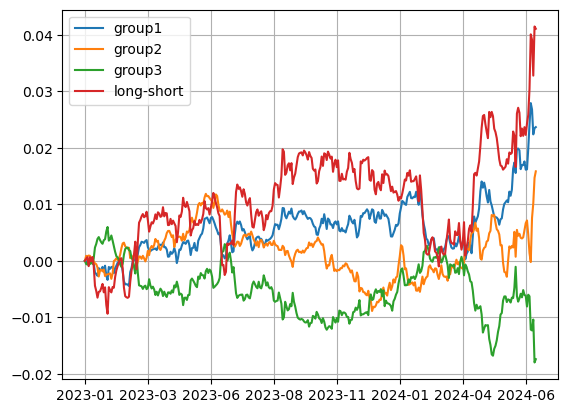

In [ ]:
# 训练期
ret5_test = factor7.loc[pd.to_datetime('2023-01-01'):pd.to_datetime('2024-06-30')]
factor_gp, factor_zp, factor_dp = cal_pool_factor(ret5_test)
#factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
# factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
# factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
# factor_gp, factor_zp, factor_dp  = exclude_QS(factor_gp), exclude_QS(factor_zp), exclude_QS(factor_dp)
# factor_gp, factor_zp, factor_dp  = factor_std(winsorize(factor_gp)), factor_std(winsorize(factor_zp)), factor_std(winsorize(factor_dp))
# plot_return(factor_gp, 3)
# plot_return(factor_zp, 4)
plot_return(factor_dp, 3)
plt.grid(True)

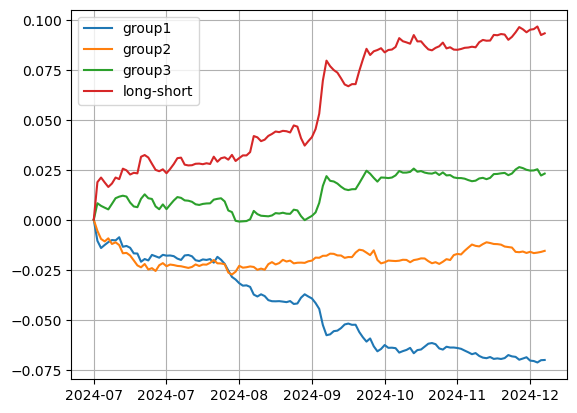

In [ ]:
# 验证期
ret5_test = factor7.loc[pd.to_datetime('2024-07-01'):pd.to_datetime('2024-12-31')]
factor_gp, factor_zp, factor_dp = cal_pool_factor(ret5_test)
#factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
# factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
# factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
# factor_gp, factor_zp, factor_dp  = exclude_QS(factor_gp), exclude_QS(factor_zp), exclude_QS(factor_dp)
# factor_gp, factor_zp, factor_dp  = factor_std(winsorize(factor_gp)), factor_std(winsorize(factor_zp)), factor_std(winsorize(factor_dp))
# plot_return(factor_gp, 3)
# plot_return(factor_zp, 4)
plot_return(factor_dp, 3)
plt.grid(True)

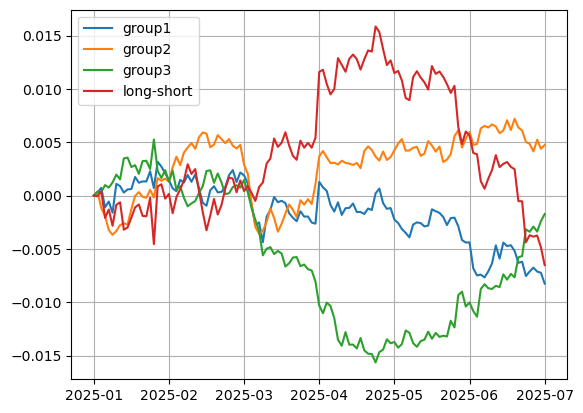

In [ ]:
# 测试期
ret5_test = factor7.loc[pd.to_datetime('2025-01-01'):pd.to_datetime('2025-07-04')]
factor_gp, factor_zp, factor_dp = cal_pool_factor(ret5_test)
#factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
# factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
# factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
# factor_gp, factor_zp, factor_dp  = exclude_QS(factor_gp), exclude_QS(factor_zp), exclude_QS(factor_dp)
# factor_gp, factor_zp, factor_dp  = factor_std(winsorize(factor_gp)), factor_std(winsorize(factor_zp)), factor_std(winsorize(factor_dp))
# plot_return(factor_gp, 3)
# plot_return(factor_zp, 4)
plot_return(factor_dp, 3)
plt.grid(True)

In [ ]:
data_open_min = D.features(instruments = instruments, fields = ['$open'], start_time = '2022-01-01', end_time = '2025-07-07', freq = '1min').unstack().T.droplevel(0)
data_high_min = D.features(instruments = instruments, fields = ['$high'], start_time = '2022-01-01', end_time = '2025-07-07', freq = '1min').unstack().T.droplevel(0)
data_low_min = D.features(instruments = instruments, fields = ['$low'], start_time = '2022-01-01', end_time = '2025-07-07', freq = '1min').unstack().T.droplevel(0)
data_close_min = D.features(instruments = instruments, fields = ['$close'], start_time = '2022-01-01', end_time = '2025-07-07', freq = '1min').unstack().T.droplevel(0)
data_volume_min = D.features(instruments = instruments, fields = ['$volume'], start_time = '2022-01-01', end_time = '2025-07-07', freq = '1min').unstack().T.droplevel(0)
data_amount_min = D.features(instruments = instruments, fields = ['$amount'], start_time = '2022-01-01', end_time = '2025-07-07', freq = '1min').unstack().T.droplevel(0)


In [ ]:
data_amount_min.loc['2025-3-19'] = data_close_min.loc['2025-3-19'] * data_volume_min.loc['2025-3-19']
data_amount_min.loc['2025-3-20'] = data_close_min.loc['2025-3-20'] * data_volume_min.loc['2025-3-20']
data_amount_min.loc['2025-3-21'] = data_close_min.loc['2025-3-21'] * data_volume_min.loc['2025-3-21']

In [ ]:
date_list = [date.strftime('%Y-%m-%d') for date in data_close.loc['2022-1-1':'2025-07-07'].index]
for date in date_list:
    data_close_min.loc[date] = data_close_min.loc[date].fillna(method = 'ffill')

In [ ]:
date_list = [date.strftime('%Y-%m-%d') for date in data_close.loc['2022-1-1':'2025-07-07'].index]
for date in date_list:
    data_open_min.loc[date] = data_open_min.loc[date].fillna(method = 'ffill')

In [ ]:
data_compare_True = pd.read_csv('C:/Users/tantra/Desktop/data/比较表格/data_compare_True.csv', parse_dates=['datetime'], index_col='datetime')
data_compare_False = pd.read_csv('C:/Users/tantra/Desktop/data/比较表格/data_compare_False.csv', parse_dates=['datetime'], index_col='datetime')

In [ ]:
data_compare_True.to_csv('C:/Users/tantra/Desktop/data/比较表格/data_compare_True.csv')
data_compare_False.to_csv('C:/Users/tantra/Desktop/data/比较表格/data_compare_False.csv')

In [ ]:
#成交量比率合成因子
date_list = [date.strftime('%Y-%m-%d') for date in data_close.loc['2022-1-1':'2025-07-04'].index]

# data_compare_True = data_close_min.copy()
# for date in date_list:
#     data_compare_True.loc[date] = data_close_min.loc[date] > data_close_min.loc[date].shift(1)

# data_compare_False = data_close_min.copy()
# for date in date_list:
#     data_compare_False.loc[date] = data_close_min.loc[date] <= data_close_min.loc[date].shift(1)

# data_compare_True = pd.read_csv('C:/Users/tantra/Desktop/data/比较表格/data_compare_True.csv', parse_dates=['datetime'], index_col='datetime')
# data_compare_False = pd.read_csv('C:/Users/tantra/Desktop/data/比较表格/data_compare_False.csv', parse_dates=['datetime'], index_col='datetime')

data_compare_True = data_close_min > data_close_min.shift(1)
data_compare_False = data_close_min <= data_close_min.shift(1)

drop_index =[]
for date in date_list:
    drop_index.extend([data_compare_True.loc[date].index[0], data_compare_True.loc[date].index[-1]])
data_compare_True.drop(index = drop_index, inplace = True)
data_compare_False.drop(index = drop_index, inplace = True)

factor = {}
for date in date_list:
    factor[date] = data_volume_min.loc[date][data_compare_True.loc[date]].sum() / data_volume_min.loc[date][data_compare_False.loc[date]].sum()
factor= pd.DataFrame(factor).T
factor.index = pd.to_datetime(factor.index) 

def weight_sum(series, N=2):
    weight = 1 / (sum(range(1,N+1)) / N)
    weight = pd.Series(range(1,N+1), index = series.index) * weight / N
    return (series * weight).sum()

factor_1 = factor_dict(factor.rolling(10).mean())
factor_2 = factor_dict(factor.rolling(2).apply(weight_sum))
# 合成因子,factor1、factor2为dict格式
def factor_combine(factor1, factor2, n1, n2):
    factor1 = winsorize(factor1)
    factor2 = winsorize(factor2)
    factor1 = factor_std(factor1)
    factor2 = factor_std(factor2)
    factor1 = pd.DataFrame(factor1).T
    factor2 = pd.DataFrame(factor2).T
    conbined_factor = n1 * factor1 + n2 * factor2
    return conbined_factor

factor1 = factor_combine(factor_1, factor_2, 0.3, 0.7)
factor1.dropna(how='all', inplace=True)

In [ ]:
# 估波指标
def cal_factor(series):
    R1 = series / series.shift(1) - 1
    R2 = series / series.shift(2) - 1
    RC = R1 + R2
    return RC.mean()

factor = data_close_min.resample('D').apply(cal_factor)
factor.index = pd.to_datetime(factor.index)
factor.dropna(how='all', inplace=True)

def weight_sum(series, N=3):
    weight = 1 / (sum(range(1,N+1)) / N)
    weight = pd.Series(range(1,N+1), index=series.index) * weight / N
    return (series * weight).sum()

factor2 = factor.rolling(3).apply(weight_sum)
factor2.dropna(how='all', inplace=True)

In [ ]:
factor_analyse(factor_new.rolling(4).apply(lambda x : weight_sum(x, N=4)))

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.207437 -0.312569 -0.339903 -0.372352 -0.277151 -0.086293   
多头年化超额    0.047829  0.086539  0.047062  0.148089  0.028704 -0.035540   
多头超额胜率    0.519553  0.561453  0.564246  0.612903  0.548387  0.459677   
多空夏普比率    0.981888  2.454179  1.193495  2.136941  1.270394 -1.346087   
概率1       0.539823  0.731563  0.690265  0.609524  0.600000  0.171429   
概率2       0.380531  0.616519  0.634218  0.542857  0.400000  0.295238   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.465820 -0.628390 -0.652585  
多头年化超额    0.155978  0.183685  0.109084  
多头超额胜率    0.572727  0.645455  0.690909  
多空夏普比率    1.888080  6.598027  5.444118  
概率1       0.604396  1.000000  0.835165  
概率2       0.714286  0.945055  0.879121

In [ ]:
#模糊关联度因子
def cal_factor(series):
    series = series[1:-1]
    return_min = series / series.shift(1) - 1
    return_std = return_min.rolling(5).std()
    return_std_std = return_std.rolling(5).std()
    factor_value = return_std_std.corrwith(data_amount_min.loc[series.index])
    return factor_value

factor_3 = data_close_min.resample('D').apply(cal_factor)
factor_3 = factor_3.dropna(how='all').dropna(how='all', axis=1)
factor3 = factor_3.rolling(4).mean()
factor3 = factor3.dropna(how='all', inplace=True)

In [ ]:
# 钱德动量摆动因子
date_list = [date.strftime('%Y-%m-%d') for date in data_close.loc['2022-1-1':'2025-07-04'].index]

# drop_index =[]
# for date in date_list:
#     drop_index.extend([data_compare_True.loc[date].index[0], data_compare_True.loc[date].index[-1]])

# data_compare_True = data_close_min.copy()
# for date in date_list:
#     data_compare_True.loc[date] = data_close_min.loc[date] > data_close_min.loc[date].shift(1)
# data_compare_True.drop(index = drop_index, inplace = True)

# data_compare_False = data_close_min.copy()
# for date in date_list:
#     data_compare_False.loc[date] = data_close_min.loc[date] <= data_close_min.loc[date].shift(1)
# data_compare_False.drop(index = drop_index, inplace = True)

data_compare_True = data_close_min > data_close_min.shift(1)
data_compare_False = data_close_min <= data_close_min.shift(1)

drop_index =[]
for date in date_list:
    drop_index.extend([data_compare_True.loc[date].index[0], data_compare_True.loc[date].index[-1]])
data_compare_True.drop(index = drop_index, inplace = True)
data_compare_False.drop(index = drop_index, inplace = True)

factor_4 = {}
data_abs = np.abs(data_close_min - data_close_min.shift(1))
for date in date_list:
    SU = data_abs.loc[date][data_compare_True.loc[date]].sum()
    SD = data_abs.loc[date][data_compare_False.loc[date]].sum()
    factor_4[date] = (SU - SD) / (SU + SD)
factor_4 = pd.DataFrame(factor_4).T
factor_4.index = pd.to_datetime(factor_4.index) 
factor4 = factor_4.rolling(3).mean()
factor4.dropna(how='all',inplace=True)

In [ ]:
factor_analyse(factor_4.rolling(3).mean())

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.113714 -0.256746 -0.218235 -0.307634 -0.276209 -0.159653   
多头年化超额    0.008499  0.055215  0.017870  0.158214  0.028061  0.040741   
多头超额胜率    0.511173  0.572626  0.547486  0.564516  0.508065  0.540323   
多空夏普比率    0.399291  2.153187  0.497910  2.888912  1.582713 -0.215232   
概率1       0.463127  0.672566  0.533923  0.752381  0.590476  0.161905   
概率2       0.333333  0.519174  0.519174  0.571429  0.323810  0.466667   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.320000 -0.631784 -0.791818  
多头年化超额    0.065365  0.125904  0.118490  
多头超额胜率    0.509091  0.581818  0.672727  
多空夏普比率    1.078664  6.290708  6.069048  
概率1       0.194444  1.000000  0.916667  
概率2       0.333333  0.611111  1.000000

In [ ]:
# 模糊金额比因子
def cal_factor(series):
    series = series[1:-1]
    min_index = series.index
    return_min = series / series.shift(1) - 1
    return_std = return_min.rolling(5).std()
    return_std_std = return_std.rolling(5).std()
    return_std_std_mean = return_std_std.mean()
    return data_amount_min.loc[min_index][return_std_std > return_std_std_mean].mean() / data_amount_min.loc[min_index].mean()

factor_5 = data_close_min.resample('D').apply(cal_factor)
factor_5.dropna(how='all',inplace=True)
factor5 = factor_5.rolling(4).mean()
factor5.dropna(how='all',inplace=True)

In [ ]:
# 动量修正因子
def cal_factor(df):
    df = df[1:-1]
    close_max = df.rolling(2).max()
    return ((df - df.shift(1)) / close_max).mean()

factor_6 = data_close_min.resample('D').apply(cal_factor)
factor_6.dropna(how='all', inplace=True)

def weight_sum(series, N=3):
    weight = 1 / (sum(range(1,N+1)) / N)
    weight = pd.Series(range(1,N+1), index = series.index) * weight / N
    return (series * weight).sum()

factor6 = factor_6.rolling(3).apply(weight_sum)
factor6.dropna(how='all', inplace=True)

In [ ]:
factor_analyse(factor_6.rolling(3).apply(lambda x : weight_sum(x, N=3)))

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.197818 -0.274887 -0.294718 -0.382547 -0.275297 -0.049801   
多头年化超额    0.021214  0.053356  0.034672  0.169167  0.016130 -0.045672   
多头超额胜率    0.491620  0.541899  0.564246  0.620968  0.548387  0.459677   
多空夏普比率    0.890337  1.752091  0.911080  2.021945  1.028862 -1.225209   
概率1       0.578171  0.651917  0.619469  0.590476  0.628571  0.228571   
概率2       0.315634  0.463127  0.640118  0.638095  0.371429  0.266667   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.473123 -0.568382 -0.545260  
多头年化超额    0.136856  0.126301  0.085617  
多头超额胜率    0.527273  0.663636  0.618182  
多空夏普比率    1.747972  5.246102  4.073056  
概率1       0.648352  0.989011  0.857143  
概率2       0.714286  0.846154  0.879121

In [ ]:
# 动态买卖气指标
date_list = [date.strftime('%Y-%m-%d') for date in data_close.loc['2022-1-1':'2025-7-04'].index]

data_compare_DTM = data_open_min > data_open_min.shift(1)
data_compare_DBM = data_open_min >= data_open_min.shift(1)

drop_index =[]
for date in date_list:
    drop_index.extend([data_compare_DTM.loc[date].index[0], data_compare_DTM.loc[date].index[-1]])

data_compare_DTM.drop(index = drop_index, inplace = True)
data_compare_DBM.drop(index = drop_index, inplace = True)

factor7 = {}
HO = data_high_min - data_open_min
OO = data_open_min - data_open_min.shift(1)
OL = data_open_min - data_low_min
DTM = np.maximum(HO,OO)[data_compare_DTM]
DBM = np.maximum(OL,OO)[data_compare_DBM]
for date in date_list:               
    STM = DTM.loc[date].sum()
    SBM = DBM.loc[date].sum()
    factor7[date] = (STM - SBM) / np.maximum(STM,SBM)
factor7 = pd.DataFrame(factor7).T
factor7.index = pd.to_datetime(factor7.index)

In [ ]:
factor_analyse(factor7)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.159468 -0.298927 -0.123949 -0.368406 -0.195538  0.099029   
多头年化超额    0.010617  0.030736  0.013924  0.071487 -0.029641  0.048521   
多头超额胜率    0.484680  0.515320  0.512535  0.528000  0.528000  0.520000   
多空夏普比率    0.332584  1.646646  0.107936  1.792937 -0.501756  3.195328   
概率1       0.358824  0.594118  0.447059  0.594340  0.424528  0.792453   
概率2       0.361765  0.447059  0.358824  0.424528  0.245283  0.566038   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.314045 -0.350245 -0.095264  
多头年化超额    0.170282  0.009227 -0.017345  
多头超额胜率    0.636364  0.471074  0.429752  
多空夏普比率    1.398301  0.054739 -1.392458  
概率1       0.455446  0.326733  0.445545  
概率2       0.643564  0.465347  0.158416

In [ ]:
# 随波逐流因子
hl_return = (data_close / data_open - 1).rolling(20).mean().dropna(how='all')
date_list = [date.strftime('%Y-%m-%d') for date in hl_return.index[:-1]]
factor = {}
for date in date_list:
    xdkp_return = data_close_min.loc[date] / data_close_min.loc[date].iloc[0] - 1
    xdkp_return_aligned, hl_return_aligned = xdkp_return.align(hl_return.loc[date], axis=1, join='inner')
    gw_amount = data_amount_min.loc[date][xdkp_return_aligned > hl_return_aligned].sum()
    dw_amount = data_amount_min.loc[date][xdkp_return_aligned < hl_return_aligned].sum()
    gdec = (gw_amount - dw_amount) / marketcap.loc[date]
    factor[date] = gdec

gdec = pd.DataFrame(factor).T 
gdec.index = pd.to_datetime(gdec.index)

def col_corr(series):
    series = np.abs(series.dropna())
    n = len(series)
    return (series.sum() - 1) / (n-1)

factor = {}
for date in gdec.index[9:]:
    df = gdec.iloc[gdec.index.get_loc(date)-9 : gdec.index.get_loc(date)+1].dropna(thresh=9, axis=1)
    corr = df.corr(method='spearman')
    factor[date] = corr.apply(col_corr)

factor8 = pd.DataFrame(factor).T
factor8 = factor8.reindex(columns=data_close.columns)

In [ ]:
factor_analyse(factor8)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR  0.149146  0.119463 -0.003856  0.298949  0.227185  0.112594   
多头年化超额    0.048616  0.013293 -0.005963  0.139813  0.049953  0.010400   
多头超额胜率    0.544693  0.500000  0.494413  0.524194  0.532258  0.500000   
多空夏普比率    0.589404  0.109429 -1.255649  2.169067  2.841007  0.058566   
概率1       0.410029  0.271386  0.280236  0.561905  0.733333  0.476190   
概率2       0.424779  0.389381  0.271386  0.790476  0.371429  0.523810   

               测试期                      
               高平池       中平池       低平池  
RankICIR  0.292364  0.206553  0.136644  
多头年化超额    0.046847  0.047477  0.010327  
多头超额胜率    0.454545  0.581818  0.518182  
多空夏普比率    0.073758  2.142178  0.746949  
概率1       0.417582  0.637363  0.648352  
概率2       0.296703  0.560440  0.285714

In [ ]:
# 平均真实波幅
date_list = [date.strftime('%Y-%m-%d') for date in data_close.loc['2022-1-1':'2025-07-04'].index]
factor9 = {}
for date in date_list:
    high_low = data_high_min.loc[date] - data_low_min.loc[date]
    close_high = data_close_min.loc[date].shift(1) - data_high_min.loc[date]
    abs_close_low = np.abs(data_close_min.loc[date].shift(1) - data_low_min.loc[date])
    atr = np.maximum(np.maximum(high_low, close_high), abs_close_low)
    ATR = atr.iloc[1:-1].mean()
    factor9[date] = ATR
factor9 = pd.DataFrame(factor9).T
factor9.index = pd.to_datetime(factor9.index)

In [ ]:
# 耀眼收益率因子
date_list = [date.strftime('%Y-%m-%d') for date in data_close.loc['2022-1-1':'2025-07-04'].index]
factor_10 = {}
for date in date_list:
    volume_up = (data_volume_min.loc[date] - data_volume_min.loc[date].shift(1)).mean() + (data_volume_min.loc[date] - data_volume_min.loc[date].shift(1)).std()
    volume_up_compare = data_volume_min.loc[date] > volume_up
    yy_return = (data_close_min / data_close_min.shift(1) - 1).loc[date][volume_up_compare.iloc[1:-1]].mean()
    factor_10[date] = yy_return

factor_10 = pd.DataFrame(factor_10).T
factor_10.index = pd.to_datetime(factor_10.index)

def cal_factor(factor,N):
    factor_return = {}
    factor_mean = factor.rolling(N).mean().dropna(how='all')
    date_list = factor_mean.index
    for date in date_list:
        factor_return[date] = np.abs(factor_mean.loc[date] - factor_mean.loc[date].mean())
    return pd.DataFrame(factor_return).T

factor10 = cal_factor(factor_10,5)

In [ ]:
factor_analyse(factor10)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.328388 -0.186719 -0.113388 -0.405995 -0.203869 -0.052442   
多头年化超额    0.061057  0.022315  0.027053  0.108707  0.046114 -0.058621   
多头超额胜率    0.562674  0.543175  0.534819  0.584000  0.568000  0.472000   
多空夏普比率    1.540564  1.349605  0.984300  2.893932  3.177415 -1.290939   
概率1       0.520588  0.517647  0.614706  0.811321  0.518868  0.301887   
概率2       0.479412  0.417647  0.429412  0.745283  0.415094  0.188679   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.405253 -0.168001  0.019441  
多头年化超额    0.255495 -0.002511 -0.016871  
多头超额胜率    0.611570  0.446281  0.471074  
多空夏普比率    3.509189  0.900144 -1.175013  
概率1       0.683168  0.544554  0.435644  
概率2       0.782178  0.168317  0.188119

In [ ]:
# 朝没晨雾因子


In [ ]:
cal_corr_matrix([factor_5, factor10, SPR, factor1_net, factor2_net, factor5_net, factor8_net], ['溢价率', '期权价值偏移', '纯债溢价率', 'factor1', 'factor2', 'factor5', 'factor8'])

,溢价率,期权价值偏移,纯债溢价率,factor1,factor2,factor5,factor8
溢价率,1.0,0.999611,0.08039,0.044394,0.082653,0.739268,-0.04048
期权价值偏移,0.999611,1.0,0.080008,0.044437,0.082404,0.738917,-0.040405
纯债溢价率,0.08039,0.080008,1.0,0.0,0.004072,0.0,0.001156
factor1,0.044394,0.044437,0.0,1.0,0.21066,0.067024,-0.010374
factor2,0.082653,0.082404,0.004072,0.21066,1.0,0.113453,-0.0
factor5,0.739268,0.738917,0.0,0.067024,0.113453,1.0,-0.063628
factor8,-0.04048,-0.040405,0.001156,-0.010374,-0.0,-0.063628,1.0


In [ ]:
# # 高中平池 合成因子
# factor1_net = pd.DataFrame(net_factor(factor1,[yjl, OVD])).T
# factor2_net = pd.DataFrame(net_factor(factor2,[yjl, OVD, factor1_net])).T
# factor8_net = pd.DataFrame(net_factor(factor8, [yjl, OVD, factor1_net, factor2_net])).T
# factor5_net = pd.DataFrame(net_factor(factor5, [yjl, OVD, factor1_net, factor2_net, factor8_net])).T
# yjl_std = pd.DataFrame(factor_std(winsorize(factor_dict(yjl)))).T
# OVD_std = pd.DataFrame(factor_std(winsorize(factor_dict(OVD)))).T
# #SPR_std = factor_std(winsorize(factor_dict(SPR)))
# factor1_net_std = pd.DataFrame(factor_std(winsorize(factor_dict(factor1_net)))).T
# factor2_net_std = pd.DataFrame(factor_std(winsorize(factor_dict(factor2_net)))).T
# factor8_net_std = pd.DataFrame(factor_std(winsorize(factor_dict(factor8_net)))).T
# factor5_net_std = pd.DataFrame(factor_std(winsorize(factor_dict(factor5_net)))).T
# combined_factor = yjl_std + OVD_std + factor1_net_std + factor2_net_std - factor8_net_std + factor5_net_std

In [ ]:
# 高平池合成因子(方法一)
yjl_std = win_std(yjl)
OVD_std = win_std(OVD)
factor_2 = win_std(factor2)
factor_5 = win_std(factor5)
factor_8 = win_std(factor8)
factor_1 = win_std(factor1)
OVD_net = pd.DataFrame(net_factor(OVD_std,[yjl_std])).T
factor2_net = pd.DataFrame(net_factor(factor_2,[yjl_std,OVD_net])).T
factor5_net = pd.DataFrame(net_factor(factor_5,[yjl_std,OVD_net,factor2_net])).T
factor8_net = pd.DataFrame(net_factor(factor_8,[yjl_std,OVD_net,factor2_net,factor5_net])).T
factor1_net = pd.DataFrame(net_factor(factor_1,[yjl_std,OVD_net,factor2_net,factor5_net,factor8_net])).T
combined_factor_GP = yjl_std + OVD_net + factor2_net + factor5_net - factor8_net + factor1_net

In [ ]:
factor_analyse(combined_factor_GP)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.428706 -0.512403 -0.334985 -0.782779 -0.607336 -0.128866   
多头年化超额    0.070177  0.057638  0.054365  0.294626  0.131230  0.014716   
多头超额胜率    0.564246  0.550279  0.592179  0.645161  0.653226  0.572581   
多空夏普比率    2.013396  2.597281  1.578376  5.995598  4.359474  1.415396   
概率1       0.634218  0.702065  0.675516  0.980952  0.857143  0.419048   
概率2       0.424779  0.584071  0.536873  0.838095  0.619048  0.495238   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.688338 -0.715236 -0.561359  
多头年化超额    0.276280  0.079161  0.060369  
多头超额胜率    0.650000  0.600000  0.591667  
多空夏普比率    5.493941  5.098064  2.765244  
概率1       0.970297  0.831683  0.495050  
概率2       0.712871  0.396040  0.683168

In [ ]:
# 高平池合成因子(方法二)
yjl_std = win_std(yjl)
OVD_std = win_std(OVD)
factor_2 = win_std(factor2)
factor_5 = win_std(factor5)
factor_8 = win_std(factor8)
factor_1 = win_std(factor1)
factor_10 = win_std(factor10)
OVD_net = pd.DataFrame(net_factor(OVD_std,[yjl_std])).T
factor10_net = pd.DataFrame(net_factor(factor_10,[yjl_std,OVD_net])).T
factor2_net = pd.DataFrame(net_factor(factor_2,[yjl_std,OVD_net,factor10_net])).T
factor5_net = pd.DataFrame(net_factor(factor_5,[yjl_std,OVD_net,factor10_net,factor2_net])).T
factor8_net = pd.DataFrame(net_factor(factor_8,[yjl_std,OVD_net,factor10_net,factor2_net,factor5_net])).T
factor1_net = pd.DataFrame(net_factor(factor_1,[yjl_std,OVD_net,factor10_net,factor2_net,factor5_net,factor8_net])).T
combined_factor_GP = yjl_std + OVD_net + factor10_net + factor2_net + factor5_net - factor8_net + factor1_net

In [ ]:
factor_analyse(combined_factor_GP)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.454324 -0.517125 -0.344544 -0.805290 -0.641071 -0.127662   
多头年化超额    0.080311  0.043874  0.043001  0.248540  0.122074  0.036203   
多头超额胜率    0.561453  0.553073  0.572626  0.612903  0.645161  0.564516   
多空夏普比率    2.135068  2.445404  1.261745  5.344068  4.756530  1.521232   
概率1       0.613569  0.734513  0.601770  0.933333  0.838095  0.476190   
概率2       0.380531  0.471976  0.563422  0.780952  0.609524  0.638095   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.729372 -0.710989 -0.564799  
多头年化超额    0.288573  0.084265  0.051050  
多头超额胜率    0.666667  0.658333  0.591667  
多空夏普比率    5.507950  5.200846  2.120487  
概率1       0.940594  0.841584  0.465347  
概率2       0.792079  0.316832  0.653465

In [ ]:
factor_2 = win_std(factor2)
factor_5 = win_std(factor5)
factor_8 = win_std(factor8)
factor_1 = win_std(factor1)
factor_10 = win_std(factor10)

In [ ]:
factor2_net = pd.DataFrame(net_factor(factor_2,[factor_10])).T
factor_analyse(factor2_net)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.183164 -0.290270 -0.305137 -0.361438 -0.294610 -0.075134   
多头年化超额    0.030916  0.077122  0.048613  0.169045  0.012061 -0.074556   
多头超额胜率    0.486034  0.544693  0.594972  0.612903  0.564516  0.508065   
多空夏普比率    1.091137  2.424450  1.207351  2.254234  0.957163 -1.099434   
概率1       0.575221  0.778761  0.681416  0.628571  0.638095  0.247619   
概率2       0.318584  0.587021  0.672566  0.676190  0.457143  0.314286   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.413012 -0.674724 -0.579742  
多头年化超额    0.162138  0.193085  0.076792  
多头超额胜率    0.558333  0.666667  0.600000  
多空夏普比率    1.162974  6.699550  4.894826  
概率1       0.534653  0.990099  0.950495  
概率2       0.732673  0.970297  0.762376

In [ ]:
factor5_net = pd.DataFrame(net_factor(factor_5,[factor_10,factor2_net])).T
factor_analyse(factor5_net)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.451757 -0.224744 -0.034767 -0.410636 -0.221979 -0.003822   
多头年化超额    0.063654  0.000038  0.013158  0.070068  0.002623 -0.084785   
多头超额胜率    0.519553  0.500000  0.544693  0.491935  0.500000  0.451613   
多空夏普比率    1.740464  0.066884 -0.496416  1.626734  0.071123 -1.726212   
概率1       0.557522  0.333333  0.271386  0.619048  0.447619  0.190476   
概率2       0.510324  0.303835  0.345133  0.666667  0.190476  0.171429   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.407466 -0.574262 -0.253521  
多头年化超额    0.007148  0.008784  0.029284  
多头超额胜率    0.500000  0.500000  0.491667  
多空夏普比率   -0.214774  1.172782  2.134234  
概率1       0.366337  0.574257  0.594059  
概率2       0.198020  0.247525  0.564356

In [ ]:
factor8_net = pd.DataFrame(net_factor(factor_8,[factor_10,factor2_net,factor5_net])).T
factor_analyse(factor8_net)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR  0.047265  0.108841 -0.002240  0.255392  0.176128  0.093308   
多头年化超额   -0.006950  0.005721  0.016455  0.083082  0.013759 -0.054541   
多头超额胜率    0.488827  0.508380  0.522346  0.564516  0.524194  0.483871   
多空夏普比率   -0.493602 -0.018857 -0.873173  1.415108  1.124953 -0.550895   
概率1       0.292035  0.294985  0.283186  0.323810  0.495238  0.371429   
概率2       0.353982  0.268437  0.339233  0.657143  0.400000  0.247619   

               测试期                      
               高平池       中平池       低平池  
RankICIR  0.309712  0.173749  0.116469  
多头年化超额    0.056280  0.037109 -0.017991  
多头超额胜率    0.495798  0.546218  0.462185  
多空夏普比率    0.544481  1.906828 -0.141862  
概率1       0.470000  0.510000  0.560000  
概率2       0.140000  0.460000  0.230000

In [ ]:
factor1_net = pd.DataFrame(net_factor(factor_1,[factor_10,factor2_net,factor5_net,factor8_net])).T
factor_analyse(factor1_net)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.172975 -0.130534 -0.185563 -0.168526 -0.322319 -0.116738   
多头年化超额   -0.016608 -0.009843  0.005863  0.065313  0.052164 -0.085098   
多头超额胜率    0.513966  0.486034  0.533520  0.564516  0.556452  0.459677   
多空夏普比率    0.017977  0.200871 -0.321733  1.653696  3.805808 -1.369123   
概率1       0.421829  0.427729  0.430678  0.638095  0.742857  0.152381   
概率2       0.448378  0.147493  0.297935  0.647619  0.333333  0.142857   

               测试期                      
               高平池       中平池       低平池  
RankICIR  0.022286 -0.263260 -0.379292  
多头年化超额    0.003935  0.028189  0.007265  
多头超额胜率    0.487395  0.521008  0.546218  
多空夏普比率    0.153845  1.551492  1.692378  
概率1       0.600000  0.460000  0.740000  
概率2       0.390000  0.440000  0.430000

In [ ]:
combined_factor = factor_10 + factor2_net + factor5_net - factor8_net
factor_analyse(combined_factor)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.391958 -0.380377 -0.212540 -0.688467 -0.385491 -0.112214   
多头年化超额    0.091297  0.051481  0.016910  0.211083  0.053800 -0.030979   
多头超额胜率    0.558659  0.564246  0.500000  0.653226  0.556452  0.508065   
多空夏普比率    1.597090  2.213574  0.767244  4.420196  1.266275 -0.893945   
概率1       0.448378  0.569322  0.528024  0.971429  0.485714  0.238095   
概率2       0.545723  0.598820  0.383481  0.790476  0.619048  0.571429   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.916407 -0.771337 -0.531024  
多头年化超额    0.296637  0.118991  0.050469  
多头超额胜率    0.616667  0.575000  0.600000  
多空夏普比率    4.086052  5.596203  2.938961  
概率1       0.613861  0.732673  0.623762  
概率2       0.851485  0.584158  0.871287

In [ ]:
combined_factor = factor_10 + factor2_net + factor5_net - factor8_net + factor1_net
factor_analyse(combined_factor)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.448070 -0.417079 -0.268670 -0.705860 -0.506544 -0.099884   
多头年化超额    0.096757  0.032638  0.026824  0.183785  0.066402 -0.102230   
多头超额胜率    0.558659  0.553073  0.569832  0.685484  0.572581  0.491935   
多空夏普比率    1.933303  2.163550  0.725785  3.786343  2.351862 -2.114049   
概率1       0.504425  0.669617  0.545723  0.952381  0.647619  0.095238   
概率2       0.560472  0.463127  0.398230  0.695238  0.476190  0.190476   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.844891 -0.836454 -0.633925  
多头年化超额    0.268909  0.119522  0.057218  
多头超额胜率    0.650000  0.616667  0.616667  
多空夏普比率    3.979830  6.521895  3.497183  
概率1       0.772277  0.900990  0.762376  
概率2       0.772277  0.534653  0.792079

In [ ]:
factor10_net = pd.DataFrame(net_factor(factor_10,[yjl_std,OVD_net])).T
factor_analyse(factor10_net)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.324877 -0.135890 -0.095273 -0.407799 -0.199977 -0.063760   
多头年化超额    0.053139  0.011464  0.022617  0.103936  0.063617 -0.050633   
多头超额胜率    0.530726  0.497207  0.522346  0.572581  0.572581  0.467742   
多空夏普比率    0.997109  0.929705  1.142169  2.815254  2.991795 -1.412410   
概率1       0.421829  0.439528  0.557522  0.847619  0.504762  0.257143   
概率2       0.427729  0.339233  0.336283  0.676190  0.419048  0.266667   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.418348 -0.173957  0.020095  
多头年化超额    0.241500  0.012548 -0.012443  
多头超额胜率    0.591667  0.475000  0.450000  
多空夏普比率    3.528857  1.479569 -0.935235  
概率1       0.712871  0.544554  0.435644  
概率2       0.801980  0.267327  0.237624

In [ ]:
factor2_net = pd.DataFrame(net_factor(factor_2,[yjl_std,OVD_net,factor10_net])).T
factor_analyse(factor2_net)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.200360 -0.352321 -0.384054 -0.361817 -0.326414 -0.141367   
多头年化超额    0.040271  0.084357  0.054107  0.160154  0.017635 -0.026133   
多头超额胜率    0.488827  0.541899  0.569832  0.588710  0.556452  0.540323   
多空夏普比率    1.071043  2.812711  1.661628  2.279372  1.186674 -0.185140   
概率1       0.522124  0.740413  0.737463  0.638095  0.457143  0.247619   
概率2       0.374631  0.545723  0.572271  0.580952  0.333333  0.428571   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.424125 -0.698724 -0.569344  
多头年化超额    0.194366  0.198427  0.061982  
多头超额胜率    0.558333  0.691667  0.600000  
多空夏普比率    1.422933  6.935995  3.897877  
概率1       0.524752  1.000000  0.861386  
概率2       0.732673  0.990099  0.673267

In [ ]:
factor5_net = pd.DataFrame(net_factor(factor_5,[yjl_std,OVD_net,factor10_net,factor2_net])).T
factor_analyse(factor5_net)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.435273 -0.195906 -0.021348 -0.419422 -0.184808  0.055104   
多头年化超额    0.037183 -0.009892  0.006664  0.059805 -0.000829  0.038219   
多头超额胜率    0.497207  0.480447  0.550279  0.491935  0.516129  0.540323   
多空夏普比率    1.275162 -0.228341 -0.398003  1.497472 -0.346109  1.918946   
概率1       0.507375  0.300885  0.294985  0.571429  0.361905  0.590476   
概率2       0.389381  0.289086  0.277286  0.590476  0.228571  0.714286   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.390361 -0.565033 -0.241550  
多头年化超额    0.024086 -0.000536  0.018139  
多头超额胜率    0.550000  0.541667  0.508333  
多空夏普比率   -0.053513  0.606915  1.279556  
概率1       0.415842  0.544554  0.514851  
概率2       0.188119  0.188119  0.534653

In [ ]:
factor8_net = pd.DataFrame(net_factor(factor_8,[yjl_std,OVD_net,factor10_net,factor2_net,factor5_net])).T
factor_analyse(factor8_net)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR  0.055569  0.153227  0.044836  0.249379  0.167047  0.089870   
多头年化超额    0.012863  0.009581  0.035008  0.107571  0.013366 -0.069154   
多头超额胜率    0.480447  0.516760  0.541899  0.572581  0.516129  0.475806   
多空夏普比率   -0.301909  0.321093  0.285593  1.923629  0.742637 -0.636061   
概率1       0.300885  0.424779  0.333333  0.390476  0.400000  0.447619   
概率2       0.356932  0.268437  0.539823  0.733333  0.447619  0.285714   

               测试期                      
               高平池       中平池       低平池  
RankICIR  0.299314  0.196193  0.144050  
多头年化超额    0.046963  0.037263 -0.010714  
多头超额胜率    0.537815  0.554622  0.478992  
多空夏普比率    0.918014  2.185513 -0.197823  
概率1       0.560000  0.570000  0.560000  
概率2       0.180000  0.510000  0.250000

In [ ]:
factor1_net = pd.DataFrame(net_factor(factor_1,[yjl_std,OVD_net,factor10_net,factor2_net,factor5_net,factor8_net])).T
factor_analyse(factor1_net)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.180452 -0.136587 -0.179054 -0.140006 -0.314336 -0.063704   
多头年化超额    0.013634 -0.016278  0.018358  0.032393  0.043869 -0.091777   
多头超额胜率    0.547486  0.472067  0.544693  0.556452  0.540323  0.419355   
多空夏普比率   -0.122634  0.040749  0.025555  1.273173  3.502161 -1.413717   
概率1       0.253687  0.345133  0.471976  0.676190  0.695238  0.066667   
概率2       0.445428  0.141593  0.342183  0.561905  0.257143  0.104762   

               测试期                      
               高平池       中平池       低平池  
RankICIR  0.034068 -0.262753 -0.368270  
多头年化超额   -0.009398  0.034770  0.023510  
多头超额胜率    0.487395  0.546218  0.537815  
多空夏普比率    0.308295  2.144714  1.608538  
概率1       0.680000  0.550000  0.660000  
概率2       0.300000  0.490000  0.620000

In [ ]:
combined_factor = yjl_std + OVD_net + factor10_net + factor2_net + factor5_net - factor8_net + factor1_net

In [ ]:
# 低平池 合成因子
SPR_std = win_std(SPR)
OVD_std = win_std(OVD)
factor_2 = win_std(factor2)
factor_8 = win_std(factor8)
factor2_net = pd.DataFrame(net_factor(factor_2,[OVD_std, SPR_std])).T
factor8_net = pd.DataFrame(net_factor(factor8, [OVD_std, SPR_std, factor2_net])).T
combined_factor = OVD_std + SPR_std + factor2_net_std - factor8_net_std

In [ ]:
factor_gp, factor_zp, factor_dp = cal_pool_factor(combined_factor.loc['2023-01-01':'2025-06-20'])
factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)

In [ ]:
bond_dict = {}
for i in factor_dp.keys():
    bond_dict[i] = factor_dp[i][:int(len(factor_dp[i])/3)].index.tolist()
bond_dict

In [ ]:
date_list = [date.strftime('%Y-%m-%d') for date in data_close.loc['2023-1-1':'2025-6-20'].index]
gr.reindex(date_list).shift(1).iloc[:,0].to_csv('C:/Users/tantra/Desktop/低平多头绝对收益.csv')

In [ ]:
factor1_net = pd.DataFrame(net_factor(factor1,[yjl,OVD,SPR])).T
factor2_net = pd.DataFrame(net_factor(factor2,[yjl,OVD,SPR,factor1_net])).T
factor8_net = pd.DataFrame(net_factor(factor8, [yjl,OVD,SPR,factor1_net,factor2_net])).T
factor5_net = pd.DataFrame(net_factor(factor5, [yjl,OVD,SPR,factor1_net,factor2_net,factor8_net])).T

In [ ]:
factor_1 = pd.DataFrame(factor_std(winsorize(factor_dict(factor1)))).T
factor_2 = pd.DataFrame(factor_std(winsorize(factor_dict(factor2)))).T
factor_5 = pd.DataFrame(factor_std(winsorize(factor_dict(factor5)))).T
factor_8 = pd.DataFrame(factor_std(winsorize(factor_dict(factor8)))).T
OVD_win= pd.DataFrame(factor_std(winsorize(factor_dict(OVD)))).T
SPR_win = pd.DataFrame(factor_std(winsorize(factor_dict(SPR)))).T
yjl_win = pd.DataFrame(factor_std(winsorize(factor_dict(yjl)))).T

In [ ]:
cal_corr_matrix([OVD_net_std, SPR_std, SPR, factor2_net_std, factor6_net_std, factor8_net_std, factor5_net], ['溢价率', '期权价值偏移', '纯债溢价率', 'factor1', 'factor2', 'factor5', 'factor8'])

,溢价率,期权价值偏移,纯债溢价率,factor1,factor2,factor5,factor8
溢价率,1.0,0.0,0.0,-0.0,-0.0,-0.0,0.0
期权价值偏移,0.0,1.0,1.0,-0.0,-0.0,0.0,0.0
纯债溢价率,0.0,1.0,1.0,-0.0,-0.0,0.0,0.0
factor1,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,0.099813
factor2,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,0.088329
factor5,-0.0,0.0,0.0,-0.0,-0.0,1.0,-0.059979
factor8,0.0,0.0,0.0,0.099813,0.088329,-0.059979,1.0


In [ ]:
OVD_net_std = pd.DataFrame(factor_std(factor_dict(OVD))).T
SPR_std = factor_std(winsorize(factor_dict(SPR)))
yjl_std = pd.DataFrame(factor_std(factor_dict(yjl_win))).T
factor1_net_std = pd.DataFrame(factor_std(factor_dict(factor1_net))).T
factor2_net_std = pd.DataFrame(factor_std(factor_dict(factor2_net))).T
factor8_net_std = pd.DataFrame(factor_std(factor_dict(factor8_net))).T
factor5_net_std = pd.DataFrame(factor_std(factor_dict(factor5_net))).T

In [ ]:
# 低平池
SPR_win = pd.DataFrame(winsorize(factor_dict(SPR))).T
OVD_win = pd.DataFrame(winsorize(factor_dict(OVD))).T
factor2_win = pd.DataFrame(winsorize(factor_dict(factor_new.rolling(8).mean().dropna(how='all')))).T
factor6_win = pd.DataFrame(winsorize(factor_dict(factor_6.rolling(3).mean().dropna(how='all')))).T
factor8_win = pd.DataFrame(winsorize(factor_dict(factor8.dropna(how='all')))).T

# OVD_net = pd.DataFrame(factor_std(net_factor(OVD_win,[SPR_win]))).T
# factor2_net = pd.DataFrame(factor_std(net_factor(factor2_win,[SPR_win,OVD_net]))).T
# factor6_net = pd.DataFrame(factor_std(net_factor(factor6_win,[SPR_win,OVD_net,factor2_net]))).T
# factor8_net = pd.DataFrame(factor_std(net_factor(factor8_win,[SPR_win,OVD_net,factor2_net]))).T
# OVD_net_std = pd.DataFrame(factor_std(factor_dict(OVD_net))).T
# SPR_std = pd.DataFrame(factor_std(factor_dict(SPR))).T
# factor2_net_std = pd.DataFrame(factor_std(factor_dict(factor2_net))).T
# factor6_net_std = pd.DataFrame(factor_std(factor_dict(factor6_net))).T
# factor8_net_std = pd.DataFrame(factor_std(factor_dict(factor8_net))).T


In [ ]:
factor_gp, factor_zp, factor_dp = cal_pool_factor(combined_factor_GP.loc['2023-01-01':'2025-07-04'])

long_bond = {}
for i in factor_gp.keys():
    long_bond[i] = factor_gp[i].iloc[:int(len(factor_gp[i])/3)]

long_bond = exclude_ST(long_bond)
long_bond = exclude_newbond(long_bond)
long_bond = exclude_QS(long_bond)

bond = {}
for i in long_bond.keys():
    bond[i] = long_bond[i].index.tolist()

pd.Series(bond).to_csv('C:/Users/tantra/Desktop/多头股池和绝对收益/日间高平多头股池.csv')

In [ ]:
long_return = {}
for i in bond.keys():
    bond_list = bond[i]
    long_return[i] = (data_close.shift(-1) / data_close - 1).loc[i,bond_list].mean()

pd.Series(long_return).shift(1).to_csv('C:/Users/tantra/Desktop/多头股池和绝对收益/日间高平多头绝对收益.csv')

In [ ]:
data_return = data_close.shift(-1) / data_close - 1
params = {}
date_list = set(factor_zp1.index) & set(factor_zp2.index) & set(factor_zp3.index) & set(factor_zp4.index) & set(factor_zp5.index) & set(factor_zp6.index)
for date in date_list:
    y = data_return.loc[date]
    x = pd.concat([factor_zp1.loc[date], factor_zp2.loc[date], factor_zp3.loc[date], factor_zp4.loc[date], factor_zp5.loc[date], factor_zp6.loc[date]], axis=1, keys=['yjl', 'OVD', 'f1', 'f2', 'f8', 'f5'])
    X = sm.add_constant(x)
    y.dropna(inplace=True)
    X.dropna(inplace=True)
    X, y = X.align(y, join='inner', axis=0)
    model = sm.OLS(y, X).fit()
    params[date] = model.params[1:]
params = pd.DataFrame(params).T
params.mean() / params.mean().sum()

In [ ]:
#date_list = [date.strftime('%Y-%m-%d') for date in data_close.loc['2023-1-1':'2025-3-28'].index]
date_list = [date for date in data_close.loc['2023-1-1':'2025-3-28'].index]
data_return = (data_close / data_close.shift(1) - 1).shift(-1)
factor = {}
for date in date_list:
    dates = data_close.iloc[data_close.index.get_loc(date)-5 : data_close.index.get_loc(date)].index
    params = {}
    for i in dates:
        y = data_return.loc[i]
        x = pd.concat([factor1_std_df.loc[i], factor2_std_df.loc[i], factor8_std_df.loc[i], factor5_std_df.loc[i]], axis=1, keys=['factor1', 'factor2', 'factor8', 'factor5'])
        X = sm.add_constant(x)
        y = y.dropna()
        X = X.dropna()
        X, y = X.align(y, join='inner', axis=0)
        model = sm.OLS(y, X).fit()
        params[i] = model.params[1:]
    params = pd.DataFrame(params).T
    params = params.mean() / params.mean().sum()
    factor[date] = factor1_std_df.loc[date] * params[0] + factor2_std_df.loc[date] * params[1] + factor8_std_df.loc[date] * params[2] + factor5_std_df.loc[date] * params[3]